## XGBoost 모델로 다음달 재고 예측하기


- 참고: https://github.com/kroonstazy/Capstone_Project_2/blob/master/Notebooks/03_XGBoost_Cap_Project_2.ipynb

생각
- industry data로 다음 3달 예측 -> 어차피 우리 회사게 가장 먼저 팔리므로 가장 이윤이 많이 나오는 상품 순으로 개수 잘라서 분배하면 되지 않을까??

### 1. Import and load data

In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import warnings

from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.impute import SimpleImputer

from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit

from sklearn import preprocessing


from tqdm import tqdm

In [51]:
warnings.filterwarnings(action='ignore')

In [52]:
file_path = "./dataset_new/"
retail_data= pd.read_csv(f"{file_path}retail_all.csv") # outlier를 삭제한 데이터
industry_data= pd.read_csv(f"{file_path}industry_all.csv")
d_h= pd.read_csv(f"{file_path}Dealer_Hierarchies.csv")


KeyboardInterrupt: 

In [ ]:
d_h

,Store,Store Owner,Region Level 1,Region Level 2,Urban/Rural
0,1,1,Eisenstadt-Umgebung,GWR,Urban
1,2,1,Politischer Bezirk Güssing,GWR,Urban
2,3,1,Politischer Bezirk Jennersdorf,GWR,Urban
3,4,1,Politischer Bezirk Jennersdorf,GWR,Urban
4,5,1,Politischer Bezirk Oberpullendorf,GWR,Urban
...,...,...,...,...,...
637,638,132,Graz Stadt,MMJ,Rural
638,639,300,Politischer Bezirk Eferding,ICA,Rural
639,640,301,Benešov,UQM,Rural
640,641,4,Nivala-Haapajärvi,IRA,Urban


In [ ]:
industry_data[industry_data['Product Type']=='Electronics']

,Industry Size,Store,Product Type,Item,Year,Month,Datetime,Region Level 1,Region Level 2,Urban/Rural,Owner
0,2,1,Electronics,Keyboard,2015,1,2015-01-01,Eisenstadt-Umgebung,GWR,Urban,1
4,2,1,Electronics,Phone Charger,2015,3,2015-03-01,Eisenstadt-Umgebung,GWR,Urban,1
9,1,1,Electronics,Power Cord,2015,4,2015-04-01,Eisenstadt-Umgebung,GWR,Urban,1
10,2,1,Electronics,Phone Charger,2015,4,2015-04-01,Eisenstadt-Umgebung,GWR,Urban,1
11,1,1,Electronics,Ear Buds,2015,4,2015-04-01,Eisenstadt-Umgebung,GWR,Urban,1
...,...,...,...,...,...,...,...,...,...,...,...
348678,3,642,Electronics,Power Cord,2022,3,2022-03-01,Koillismaa,KTR,Urban,74
348679,5,642,Electronics,Phone Charger,2022,3,2022-03-01,Koillismaa,KTR,Urban,74
348680,2,642,Electronics,Ear Buds,2022,3,2022-03-01,Koillismaa,KTR,Urban,74
348681,4,642,Electronics,Mouse,2022,3,2022-03-01,Koillismaa,KTR,Urban,74


In [ ]:
set_dt = "2022-04-01"

In [ ]:
datetime_list = list(dict.fromkeys(list(industry_data['Datetime'])))
store_list = [i for i in range(1, 643)] # 1~642

In [ ]:
product_dict = {"Power Cord":"Electronics",
                "Phone Charger":"Electronics",
                "Ear Buds":"Electronics",
                "Mouse":"Electronics",
                "Keyboard":"Electronics",
                "Milk":"Grocery",
                "Eggs":"Grocery",
                "Cereal":"Grocery",
                "Shrimp":"Grocery",
                "Noodles":"Grocery",
                "Steak":"Grocery",
                "King Crab":"Grocery",
                "Tape":"Home Goods",
                "Glue":"Home Goods",
                "Nails":"Home Goods",
                "Bracket":"Home Goods",
                "Brush":"Home Goods",
                "Paint":"Home Goods"
                }

In [ ]:
# 추가할 dataframe
new_df = pd.DataFrame(
    [],columns = ['Industry Size', 'Store', 'Product Type', 'Item', 'Year', 'Month','Datetime', 'Region Level 1', 'Region Level 2', 'Urban/Rural', 'Owner']
)

In [ ]:
from re import S


def append_new_sentence(new_df, product,d,s):
    new_df.loc[len(new_df)] = [
        0, #industry size
        s, #store
        product_dict[product], #item
        product, #product type
        int(d[:4]), # year
        int(d[5:7]), # month
        d, # datetime
        d_h.loc[s-1]['Region Level 1'],
        d_h.loc[s-1]['Region Level 2'],
        d_h.loc[s-1]['Urban/Rural'],
        d_h.loc[s-1]['Store Owner']
    ]
    


In [ ]:
# # 재고 0인 행 목록에 추가
# for d in tqdm(datetime_list):
#     for product in list(product_dict.keys()): #key
#         for s in store_list:
#             datetime_df = industry_data[(industry_data['Datetime']==d)&(industry_data['Store']==s)] # 해당 datetime의 df
#             if len(datetime_df[datetime_df['Item']==product])==0:
#                 append_new_sentence(new_df,product,d,s)

In [ ]:
# # 추가
# industry_data_1_add0 = industry_data.append(new_df, ignore_index=True)

# # 정렬 # 1,005,372 개여야함
# industry_data_1_add0.sort_values(['Datetime','Item','Store'],inplace=True)
# industry_data_1_add0.reset_index(drop=True,inplace=True)


In [ ]:
d_h

,Store,Store Owner,Region Level 1,Region Level 2,Urban/Rural
0,1,1,Eisenstadt-Umgebung,GWR,Urban
1,2,1,Politischer Bezirk Güssing,GWR,Urban
2,3,1,Politischer Bezirk Jennersdorf,GWR,Urban
3,4,1,Politischer Bezirk Jennersdorf,GWR,Urban
4,5,1,Politischer Bezirk Oberpullendorf,GWR,Urban
...,...,...,...,...,...
637,638,132,Graz Stadt,MMJ,Rural
638,639,300,Politischer Bezirk Eferding,ICA,Rural
639,640,301,Benešov,UQM,Rural
640,641,4,Nivala-Haapajärvi,IRA,Urban


In [ ]:
industry_data_1_add0 = pd.read_csv('./dataset_new/industry_data_add0.csv')

In [ ]:
# for i in tqdm(range(len(industry_data_1_add0))):
#     store = industry_data_1_add0.loc[i]['Store']
#     r1 = industry_data_1_add0.loc[i]['Region Level 1']
#     d_h_r1 = d_h.loc[store-1]['Region Level 1']
#     if d_h_r1!=r1:
#         industry_data_1_add0.loc[i,'Region Level 1']=d_h_r1

In [ ]:
print(len(set(industry_data_1_add0['Region Level 1'])))
len(set(d_h['Region Level 1']))

343


343

In [ ]:
# industry_data_1_add0.to_csv('./industry_data_add0.csv',index=False)

In [ ]:
#industry_data_1_add0 = pd.read_csv('./dataset_new/industry_data_add0_min.csv')
industry_data_1_add0.sort_values(['Datetime','Store','Item'],inplace=True)
industry_data_1_add0.reset_index(drop=True,inplace=True)
industry_data_1_add0

,Industry Size,Store,Product Type,Item,Year,Month,Datetime,Region Level 1,Region Level 2,Urban/Rural,Owner,quarter
0,0,1,Home Goods,Bracket,2015,1,2015-01-01,Eisenstadt-Umgebung,GWR,Urban,1,1
1,0,1,Home Goods,Brush,2015,1,2015-01-01,Eisenstadt-Umgebung,GWR,Urban,1,1
2,0,1,Grocery,Cereal,2015,1,2015-01-01,Eisenstadt-Umgebung,GWR,Urban,1,1
3,0,1,Electronics,Ear Buds,2015,1,2015-01-01,Eisenstadt-Umgebung,GWR,Urban,1,1
4,0,1,Grocery,Eggs,2015,1,2015-01-01,Eisenstadt-Umgebung,GWR,Urban,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
1040035,0,642,Electronics,Phone Charger,2022,6,2022-06-01,Koillismaa,KTR,Urban,74,2
1040036,0,642,Electronics,Power Cord,2022,6,2022-06-01,Koillismaa,KTR,Urban,74,2
1040037,0,642,Grocery,Shrimp,2022,6,2022-06-01,Koillismaa,KTR,Urban,74,2
1040038,0,642,Grocery,Steak,2022,6,2022-06-01,Koillismaa,KTR,Urban,74,2


In [ ]:
# Label encoding

label = preprocessing.LabelEncoder()
industry_data_encoded = pd.DataFrame()

industry_data_1_col = ['Product Type', 'Item', 'Region Level 1', 'Region Level 2', 'Urban/Rural']
for i in industry_data_1_add0.columns:
    if i in industry_data_1_col:
        industry_data_encoded[i] = label.fit_transform(industry_data_1_add0[i])
    else:
        industry_data_encoded[i] = industry_data_1_add0[i]

In [ ]:
industry_data_encoded

,Industry Size,Store,Product Type,Item,Year,Month,Datetime,Region Level 1,Region Level 2,Urban/Rural,Owner,quarter
0,0,1,2,0,2015,1,2015-01-01,31,9,1,1,1
1,0,1,2,1,2015,1,2015-01-01,31,9,1,1,1
2,0,1,1,2,2015,1,2015-01-01,31,9,1,1,1
3,0,1,0,3,2015,1,2015-01-01,31,9,1,1,1
4,0,1,1,4,2015,1,2015-01-01,31,9,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
1040035,0,642,0,13,2022,6,2022-06-01,106,21,1,74,2
1040036,0,642,0,14,2022,6,2022-06-01,106,21,1,74,2
1040037,0,642,1,15,2022,6,2022-06-01,106,21,1,74,2
1040038,0,642,1,16,2022,6,2022-06-01,106,21,1,74,2


In [ ]:
sum(industry_data_encoded[industry_data_encoded['Year']==2020]['Industry Size'])/4

34597.5

In [ ]:
set_dt = '2022-01-01'

In [ ]:
train_1 = industry_data_encoded[industry_data_encoded['Datetime'] < set_dt]
val_1 = industry_data_encoded[(industry_data_encoded['Datetime'] >= set_dt)&(industry_data_encoded['Datetime'] <'2022-04-01')] # 2022

In [ ]:
# Feature와 Target 분리
target = 'Industry Size'
features = train_1.drop([target,"Datetime",'quarter'], axis=1).columns

X_train = train_1[features]
y_train = train_1[target]
X_val = val_1[features]
y_val = val_1[target]

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(970704, 9) (970704,)
(34668, 9) (34668,)


In [ ]:
# 확인
X_train.head(3)

,Store,Product Type,Item,Year,Month,Region Level 1,Region Level 2,Urban/Rural,Owner
0,1,2,0,2015,1,31,9,1,1
1,1,2,1,2015,1,31,9,1,1
2,1,1,2,2015,1,31,9,1,1


In [ ]:
# 파이프라인 생성 및 학습
xgb_basic = make_pipeline(
    SimpleImputer(),
    RobustScaler(),
    XGBRegressor(random_state=1,
                 n_jobs=-1,
                 objective='reg:squarederror',
                 max_depth=5, # 5
                 learning_rate=0.2))

xgb_basic.fit(X_train, y_train);

In [ ]:
# 예측
y_pred = xgb_basic.predict(X_val)

# prediction값 반올림
y_pred_r =  [round(x) if round(x) >=0 else 0 for x in y_pred]

# 결과 확인

print('mae:  ', mae(y_val, y_pred_r))
print('rmse: ', np.sqrt(mse(y_val, y_pred_r)))

# 수정전
# mae:   0.5681168738391199
# rmse:  1.5965796357571027

mae:   0.7764220606899734
rmse:  1.494605892910915


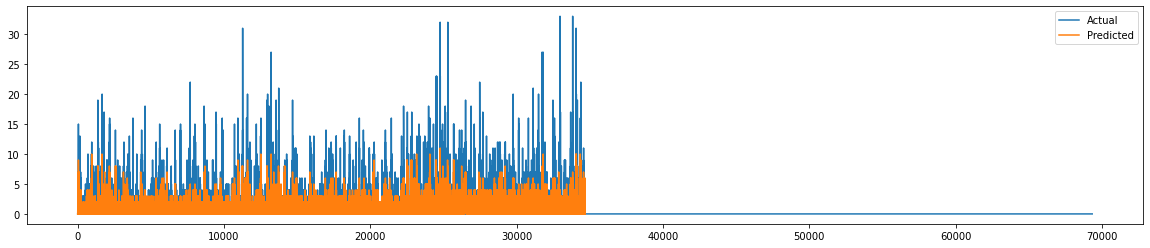

In [ ]:
plt.figure(figsize=(20, 4))

plt.plot(industry_data_encoded[industry_data_encoded['Datetime'] >= set_dt]['Industry Size'].reset_index(drop=True), label='Actual',)
plt.plot(y_pred_r, label='Predicted')



plt.legend()
plt.show();

In [ ]:
sum(y_pred_r)

31394

In [ ]:
# 빈값에 예측값 추가
newlist = list(industry_data_encoded[industry_data_encoded['Datetime']<set_dt]['Industry Size'])+y_pred_r
industry_data_encoded['Industry Size'] = newlist

In [ ]:
result = pd.DataFrame([])
result['predicted'] = y_pred_r
result.to_csv("1108순차.csv",index=False)

쫌..구리다!


### hyper parameter

In [56]:
# eval set 생성
pre_processing_part = make_pipeline(
    SimpleImputer(),
    RobustScaler())

X_train_processing = pre_processing_part.fit_transform(X_train)
X_val_processing = pre_processing_part.transform(X_val)

eval_set = [(X_train_processing, y_train),
            (X_val_processing, y_val)]

In [57]:
# 모델 생성
xgb_hyper = XGBRegressor(
    random_state=1,
    n_jobs=-1,
    objective='reg:squarederror')

# 사용할 하이퍼 파라미터
dists = {
    'max_depth': [3, 4, 5, 6, 7, 8],
    'min_child_weight': [1, 2, 3, 4],
    'gamma': [0, 0.01, 0.1, 0.2, 0.3],
    'learning_rate': [0.001, 0.01, 0.1, 0.2, 0.3]}

# cv
cv = TimeSeriesSplit(n_splits=5)

# GridSearchCV
reg_xgb_hyper = GridSearchCV(
    xgb_hyper, 
    param_grid=dists,
    cv=cv, 
    scoring='neg_root_mean_squared_error',
    verbose=0,
    n_jobs=-1
)

reg_xgb_hyper.fit(X_train_processing,
                  y_train,
                  eval_set = eval_set,
                  eval_metric='rmse',
                  early_stopping_rounds = 50);

/home/ubuntu/anaconda3/envs/py38mj/lib/python3.8/site-packages/xgboost/compat.py:31: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/home/ubuntu/anaconda3/envs/py38mj/lib/python3.8/site-packages/xgboost/compat.py:31: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/home/ubuntu/anaconda3/envs/py38mj/lib/python3.8/site-packages/xgboost/compat.py:31: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/home/ubuntu/anaconda3/envs/py38mj/lib/python3.8/site-packages/xgboost/compat.py:31: FutureWarning: pandas.Int64Index is deprecated and will be removed fr

In [ ]:
# 결과 확인
print('best hyper-parameter: ', reg_xgb_hyper.best_params_)
# best hyper-parameter:  {'gamma': 0.01, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 4}

best hyper-parameter:  {'gamma': 0.01, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 4}


In [ ]:
# cv 결과 확인
pd.DataFrame(reg_xgb_hyper.cv_results_).sort_values(by='rank_test_score').head().T

,219,99,75,463,339
mean_fit_time,0.047009,0.08692,0.044571,0.046868,0.039924
std_fit_time,0.008574,0.058549,0.005112,0.01084,0.00674
mean_score_time,0.002013,0.001905,0.001986,0.002096,0.001984
std_score_time,0.000043,0.000063,0.000076,0.000365,0.000224
param_gamma,0.01,0,0,0.2,0.1
param_learning_rate,0.3,0.3,0.2,0.3,0.3
param_max_depth,3,3,3,4,3
param_min_child_weight,4,4,4,4,4
params,"{'gamma': 0.01, 'learning_rate': 0.3, 'max_dep...","{'gamma': 0, 'learning_rate': 0.3, 'max_depth'...","{'gamma': 0, 'learning_rate': 0.2, 'max_depth'...","{'gamma': 0.2, 'learning_rate': 0.3, 'max_dept...","{'gamma': 0.1, 'learning_rate': 0.3, 'max_dept..."
split0_test_score,-0.370669,-0.370669,-0.382337,-0.388187,-0.376114


In [ ]:
# 모델 저장
model_xgb_hyper = reg_xgb_hyper.best_estimator_

# 예측
y_pred = model_xgb_hyper.predict(X_val_processing)

# prediction값 반올림
y_pred_r =  [round(x) if round(x) >=0 else 0 for x in y_pred]

# 결과 정리
print('mae :', round(mae(y_val, y_pred_r), 2))
print('rmse :', round(np.sqrt(mse(y_val, y_pred_r)), 2))

mae : 0.37
rmse : 0.71


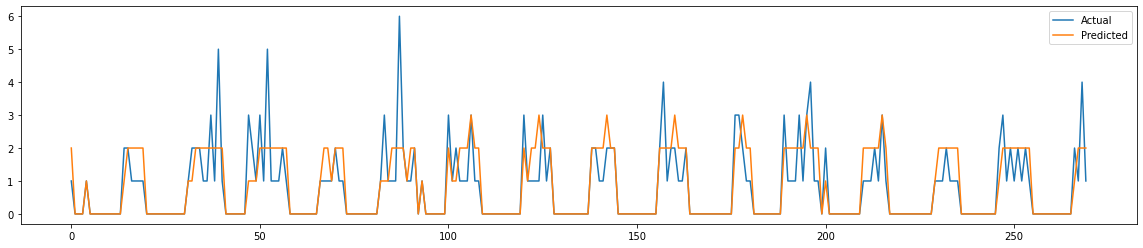

In [ ]:
plt.figure(figsize=(20, 4))
plt.plot(industry_data_encoded[industry_data_encoded['Datetime'] >= set_dt]['Industry Size'].reset_index(drop=True), label='Actual',)
plt.plot(y_pred_r, label='Predicted')


plt.legend()
plt.show();